# Course Project

### Solution by: *Latifa Al-Naimi* 

## Description

## 1. Data collection

### 1.1 Tweepy setup
I installed tweepy onto the conda environment created at the beginning of class: `conda install tweepy`. This is required to be able to use Twitter API v2 via Python. The `btoken` variable below represents the "bearer token" --a secret key that ties my personal application to a tweepy client. It has been removed prior to submission of this notebook.

In [36]:
import tweepy
import time
import re
import string
import pandas as pd
from langdetect import detect

#from twitter_authentication import btoken

In [11]:

# Authenticate this application
btoken = "AAAAAAAAAAAAAAAAAAAAAO8DWQEAAAAA6PZNjSLspN5BxUQeD%2FtDqiGdPLk%3D8qZRtLqE07yOmuPTiy9jnNvGKI16YyM1QgvRR4wvIVoY6Tq9uX"
client = tweepy.Client(btoken, wait_on_rate_limit=True)

### 1.2 Obtaining training data
#### Context
The training data I obtained is based on interactions in the time frame of a specific tweet posted by user @Aishalqahtani. The tweet is in Arabic, but in this tweet, Aisha disclosed her name and picture for the first time after years of being anonymous while living in Qatar. She posted this after seeking asylum in the UK and subsequently received a litany of responses in suppport of and criticizing her actions. The code below retrieves  metadata tied to that specific tweet.

In [56]:
origin_id = "1218892822599950343"
initial_data = client.get_tweet(origin_id, tweet_fields=['geo','referenced_tweets'])
print(initial_data)

Response(data=<Tweet id=1218892822599950343 text=سلڤادور هي عائشة القحطاني، قطرية، محبة لوطني، ولكن أمضيت ٢٢ سنة تحت القوانين القامعة للمرأة في قطر، والتي تعطي كل التفويض لذكر العائلة، القوانين التي تدهس على المعنفات وتكرههم على التنازل عن حقوقهم، اقف هنا بعد ان نجيت بذاتي من كل ذلك، لأتحدث عن تجربتي وتجربة غيري من النساء. https://t.co/XT1urKj3jX>, includes={}, errors=[], meta={})


#### Tweepy queries
Using the time frame of the above tweet, I queried all tweets in that time frame that were replies or quote tweets of the user @aishalqahtani and stored the responses in `aisha_tweets`.

In [72]:
# Querying replies and retweets to Aisha's 'tweet of independence'
aisha_tweets = []
for response in tweepy.Paginator(client.search_all_tweets, 
                                 query = 'to:aishalqahtani OR retweets_of:aishalqahtani',
                                 user_fields = ['username', 'name', 'location', 'profile_image_url'],
                                 tweet_fields = ['id','created_at', 'geo', 'public_metrics', 'text'],
                                 expansions = 'author_id',
                                 start_time = '2020-01-19T06:00:00Z',
                                 end_time = '2020-01-30T00:00:00Z',
                              max_results=500):
    time.sleep(1)
    aisha_tweets.append(response)

NameError: name 'client' is not defined

In [71]:
# Example response tweet
aisha_tweets[10].data[2]

NameError: name 'aisha_tweets' is not defined

#### Converting responses to dataframe
Responses returned above are a complex multi-level data structure, so I created a function `to_dataframe()` so that it could be used for converting both training and test responses to data frames. The function body was obtained from this Twitter API v2 tutorial: <https://www.youtube.com/watch?v=rQEsIs9LERM>

In [47]:

def to_dataframe(responses: list): 
    result = []
    user_dict = {}
    # Loop through each response object
    for response in responses:
        # Take all of the users, and put them into a dictionary of dictionaries with the info we want to keep
        for user in response.includes['users']:
            user_dict[user.id] = {'username': user.username, 
                                  'name': user.name,
                                  'profile_image_url': user.profile_image_url,
                                  'location': user.location
                                 }
        for tweet in response.data:
            # For each tweet, find the author's information
            author_info = user_dict[tweet.author_id]
            # Put all of the information we want to keep in a single dictionary for each tweet
            result.append({'author_id': tweet.author_id, 
                           'username': author_info['username'],
                           'name': author_info['name'],
                           'author_location': author_info['location'],
                           'text': tweet.text,
                           'created_at': tweet.created_at,
                           'retweets': tweet.public_metrics['retweet_count'],
                           'replies': tweet.public_metrics['reply_count'],
                           'likes': tweet.public_metrics['like_count'],
                           'quote_count': tweet.public_metrics['quote_count']
                          })

    # Change this list of dictionaries into a dataframe
    df = pd.DataFrame(result)
    return df


In [48]:
aisha_reaction_df = to_dataframe(aisha_tweets)

In [49]:
aisha_reaction_df

,author_id,username,name,author_location,text,created_at,retweets,replies,likes,quote_count
0,1216698138125271041,Genat99952881,Genat,None,RT @sa_vadorr: هناك فتيات يتعرضن للضرب والاضطه...,2020-01-29 23:04:47+00:00,95,0,0,0
1,147036773,ArabianSaluki,Arabian Saluki,"Riyadh, Saudi Arabia",RT @sa_vadorr: طبعا قناة الجزيرة حاليا على وضع...,2020-01-29 22:42:08+00:00,182,0,0,0
2,147036773,ArabianSaluki,Arabian Saluki,"Riyadh, Saudi Arabia",RT @sa_vadorr: يا عيني!، الجديد الان انه عندما...,2020-01-29 22:39:53+00:00,77,0,0,0
3,17024104,innosinz,Nicole Deniese Harris,"Virginia, USA","@sa_vadorr 100% right, I covered not knowing i...",2020-01-29 22:08:39+00:00,0,0,0,0
4,541397323,Critic_man,ناصر,None,RT @sa_vadorr: سلڤادور هي عائشة القحطاني، قطري...,2020-01-29 21:06:45+00:00,1735,0,0,0
...,...,...,...,...,...,...,...,...,...,...
6397,953150634865430528,naah1980,نــاهــد,None,@sa_vadorr ياشماتت ابله طازه فينا 😂😂😂,2020-01-19 13:31:49+00:00,0,0,1,0
6398,2911674320,AlyafieHanan,❄ حنان اليافعي,خارجَ السّرْب,RT @sa_vadorr: جريدة الراية اثارت الرأي العام،...,2020-01-19 13:19:54+00:00,20,0,0,0
6399,1209870499284697088,keyalrumaihi,keyalrumaihi🇶🇦,"Doha, Qatar",@sa_vadorr بعد اتذمون في البلاد ذم ولسانكم طوي...,2020-01-19 11:58:23+00:00,0,0,0,0
6400,1086235403710054400,Ayshalkubaisi1,Ayshalkubaisi_,None,@sa_vadorr عيشي انسانيتچ الغير سوية مع نفسچ لا...,2020-01-19 11:46:27+00:00,0,0,0,0


In [50]:
aisha_reaction_df.to_csv('aisha_interactions.csv')

### 1.3 Obtaining test data
The method used to obtain test data is the same as training data, however, I chose a more recent incident with a different user, @noofalmaadeed, and obtained interactions within a shorter time frame (2-3 weeks).

In [51]:
noof_tweets = []
for response in tweepy.Paginator(client.search_all_tweets, 
                                 query = 'to:noofalmaadeed OR retweets_of:noofalmaadeed',
                                 user_fields = ['username', 'name', 'location', 'profile_image_url'],
                                 tweet_fields = ['id','created_at', 'geo', 'public_metrics', 'text'],
                                 expansions = 'author_id',
                                 start_time = '2021-10-11T00:00:00Z',
                                 end_time = '2021-10-30T00:00:00Z',
                              max_results=500):
    time.sleep(1)
    noof_tweets.append(response)

In [53]:
noof_reaction_df = to_dataframe(noof_tweets)
noof_reaction_df.to_csv('noof_interactions.csv')

## 2. Data cleaning
### 2.1 Removing duplicate retweets
There were several duplicate retweets listed as separate datasets, so I took measures to remove them using the drop_duplicates() function in `pandas`. I did this for both training and test and test CSV files.

* Initial number of training tweets: 6401

* Initial number of test tweets: 637

In [82]:
# Training data
df = pd.read_csv('training_duplicates.csv', 
                usecols=['text']).drop_duplicates(keep=False).reset_index()
df.to_csv('train.csv')

In [83]:
# Test data
df = pd.read_csv('test_duplicates.csv', 
                usecols=['text']).drop_duplicates(keep=False).reset_index()
df.to_csv('test.csv')

### 2.2 Offline CSV restructuring
When I retrieved the tweets using the twitter API client, I specified several meta data that were interesting to me and seemed like they might be relevant. However, this meta data was removed for this particular project as I am only analyzing the text data in the tweets for the time being. 

Steps taken offline:
* Removed non-text data (e.g. user location, name, etc) as it is irrelevant to this project. 
* Removed the old index column
* Removed header

After steps **2.1** and **2.2**, I ended up with:
* Training tweets: 3243
* Test tweets: 341

## 3. Annotation
For this project, annotation was a requirement for a number of reasons. First, there were no similar datasets that were labeled due to the niche nature of the project. Second, The tweets of interest were both in English and Arabic as both languages are used quite frequently in the geographic region I am studying. But more than that, the Arabic used is not classic Arabic, rather a specific dialect unique to that region, so correct annotations can only be administered by someone who understands them both. The alternative would be to cut out a significant portion of the dataset, but for this study (or an extension of it), both languages need to be taken into account.

### 3.1 Label description
Offline, I added a column for the label in both `training.csv` and `test.csv`.
I used the following annotations to label tweets:
* 1 for supportive sentiment
* -1 for opposing or invalidating sentiment
* 0 for irrelevant, neutral or ambiguous tweets 

### 3.2 Annotation results:
The goal was to end up with $1000$ training data points, however, due to time constraints, I managed $816$ (negative and positive). Including zeroes, total annotations are $1515$.

| Dataset  |  1  | -1  | 0    |
| -------- |-----|-----|------|
| Training | 231 | 585 | 699  |
| Test     | 75  | 65  | 186  |


### 3.3 Dataset refinement
Due to the ambiguous nature of the zero-labeled tweets, I've decided to remove them from consideration (in the following code block). I also remove @mentions from the tweet contents.

In [5]:
train_df = pd.read_csv('train.csv', header=None)
# remove nonlabeled rows
train_df = train_df.dropna()  

# remove rows with 0 labels 
train_df = train_df.loc[train_df[1] != 0] 

# remove mentions
train_df[2] = train_df[2].replace(r'@.*?(?=\s)', '', regex=True)

train_df

#train_df.to_csv('train.csv')

,0,1,2
0,0,1.0,"100% right, I covered not knowing it was my c..."
1,1,-1.0,كمية طاقه سلبيه في ويهج وكلامج..مسكينه انتي و...
2,3,-1.0,كذب من قال إن التعري يزيد المرأة جمالا https:...
3,4,-1.0,الله لا يبلانا بس ويسترنا فالدنيا والاخرة
4,5,-1.0,(يَا أَيُّهَا النَّبِيُّ قُل لِّأَزْوَاجِكَ و...
...,...,...,...
2515,3237,1.0,you gorgeous mashallah ✨✨✨ thank you for shar...
2516,3238,1.0,اما الان فأستطيع ان اكون صوت للواتي يردن ان يش...
2517,3239,1.0,يجب ان يعي الجميع بكمية الحقوق المسلوبة من الم...
2518,3242,-1.0,عيشي انسانيتچ الغير سوية مع نفسچ لاتحرضين الب...


In [6]:
test_df = pd.read_csv('test.csv', header=None)

# remove nonlabeled rows
test_df = test_df.dropna()  

# remove rows with 0 labels 
test_df = test_df.loc[test_df[1] != 0] 

# remove mentions
test_df[2] = test_df[2].replace(r'@.*?(?=\s)', '', regex=True)

test_df

#test_df.to_csv('test.csv')

,0,1,2
0,0,1.0,شلون وثقتي💔؟ ٪يارب انج بخير
2,2,-1.0,وايد مفتلمه
3,3,1.0,هل انتي بجير حنآ معاك وا نحبك كثير 💞
4,4,1.0,Still worried for u… #وين_نوف
11,11,1.0,Stay safe remember be strong! We love u
...,...,...,...
319,320,1.0,الله يحفظك وماعليك شر ان شاءالله انتي في بلد ...
322,323,-1.0,اتمنى ان اللي يعرف نوف يتركها في حالها \nتعيش...
323,331,1.0,انت اقوى من ما تعتقدين يا نوف\nرغم ما تتحفظين...
324,333,-1.0,مافي مكان مثالي الا بيت والديج\nقري مكانك و ...


## 4. Feature extraction

In [ ]:
Y_train = train_df.iloc[0:, 1].values
text_train = train_df.iloc[0:, 2].values

Y_test = test_df.iloc[0:, 1].values
text_test = test_df.iloc[0:, 2].values

### 4.1 Detect language 
The following code blocks create separate dataframes for English and Arabic tweets because the tokenization processes are different for each.

### 4.1 Feature prep function

In [164]:
import nltk 
from nltk.corpus import stopwords

arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations
stopwords_list = stopwords.words('arabic')
stopwords_list += stopwords.words('english')

def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

def preprocess(text: str):
    text = text.lower()   
     #Convert www.* or https?://* to " "
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text)
    
    #Replace #word with word
    text = re.sub(r'#([^\s]+)', r'\1', text)

    # remove punctuations
    text = remove_punctuations(text)
    
    
    # remove repeated letters
    text = re.sub(r'(.)\1+', r'\1\1', text)
    
    # remove arabic and english stop words
    splt = text.split()
    for i,word in enumerate(splt):
        if word in stopwords_list:
            splt[i]=splt[i].replace(word,'')
            
    text = ' '.join(splt)
    
    return text

In [168]:
# Testing preprocessing function 
preprocess(text_train[10])

'ياعزتي  حسبنا الله ونعم الوكيل   غرر بدينك وفكرك الله يلطف بحالك وحال امك وأهلك واحبابك اتعبتيهم ذبحتهم وهم أحياء الله يلسط   ساعدك وغرر  عذاب الهون  الدنيا والآخرة'

### 4.2 Vectorization
#### TF-IDF
I decided to first test the TF-IDF vectorizer due to its nature of rating more important words appropriately.

In [169]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

vect_tf = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', ngram_range=(1, 2))
X_train_tfidf = vect_tf.fit_transform(preprocess(tweet) for tweet in text_train)
X_test_tfidf = vect_tf.transform(preprocess(tweet) for tweet in text_test)

# print(vect.get_feature_names())
# print(X_train.shape)

#### CountVectorizer
I wanted to compare the TF-IDF vectorization algorithm with a simpler implementation, the CountVectorizer, and see how that affects accuracies.

In [170]:
from sklearn.feature_extraction.text import CountVectorizer

vect_ct = CountVectorizer(strip_accents='unicode', ngram_range=(1,2))
X_train_ct = vect_ct.fit_transform(preprocess(tweet) for tweet in text_train)
X_test_ct = vect_ct.transform(preprocess(tweet) for tweet in text_test)


In [139]:
# import numpy as np
# class Tokenizer:
    
#     def __init__(self):
#         self.tokenizer_dict: Dict = {}
#         self.tokenize_length = 0
        
#     def fit(self, array_strings, split_param=" "):
#         """ creates tokenize dictionary """
#         counter = 1
#         for string in array_strings:
#             words = string.split(split_param)
#             for word_i in words:
#                 if word_i not in self.tokenizer_dict:
#                     self.tokenizer_dict[word_i] = counter
#                     counter += 1
#         # make a tokenizer length
#         self.tokenize_length = counter
        
#     def transform(self, array_strings, split_param=" ", count=None):
#         """ returns a vector """
#         tokenized_matrix = []
#         for string in array_strings:
#             string_vec = np.zeros((self.tokenize_length))
#             words = string.split(split_param)
#             for word_i in words:
#                 if word_i in self.tokenizer_dict:
#                     index = self.tokenizer_dict[word_i]
#                     if count:
#                         string_vec[index] += 1
#                     else: 
#                         string_vec[index] = 1
#             tokenized_matrix.append(string_vec)
#         return tokenized_matrix
    
#     def fit_transform(self, array_strings):
#         self.fit(array_strings)
#         return self.transform(array_strings)

In [142]:
vect = Tokenizer()
vect.fit(preprocess(tweet) for tweet in text_train)
X_train = vect.transform(preprocess(tweet) for tweet in text_train)
X_test = vect.transform(preprocess(tweet) for tweet in text_test)

## 5. Classifier setup & hyperparameter tuning
### 5.1 Model 1: logistic regression
Hyperparameter tuning with 10-fold grid search cross-validation.

In [158]:
base_classifier = LogisticRegression(penalty='l2', tol=1e-2, max_iter=500, random_state=123)

base_classifier.fit(X_train, Y_train)
base_classifier.score(X_test, Y_test)

# get the top coefficeints and the index of those (say top 10; both neg and pos top 10)
coeff = [(ind, val) for ind, val in enumerate(base_classifier.coef_[0])]
top_10 = list(filter(lambda a: a[1] > 0.5, coeff))
# bottom_10 = 

top_10_ind = [i[0] for i in top_10]
# from the top 10, find what those words are

for key, val in vect.tokenizer_dict.items():
    if val in top_10_ind:
        print(key)

and
be
يكون
المرأة
لك
جميلة
you
of
عقبالي
معك
حبيبتي
ولكن
يحفظك
شر
proud
يحفظج
قلبي
❤️
brave
زالت
rt
سعيدة
كوني
معاك
اتمنى
حرة
ربي
حياتك
موفقه
الحياة
يسهل
ويحفظج
مبروك
عقبال
فخر


In [163]:
results

{'results': {'LogisticRegression': 0.8188405797101449,
  'AdaBoostClassifier': 0.6811594202898551,
  'KNN': 0.5579710144927537,
  'SVM': 0.959409594095941}}

logistic regression
adaboost
KNN
SVM


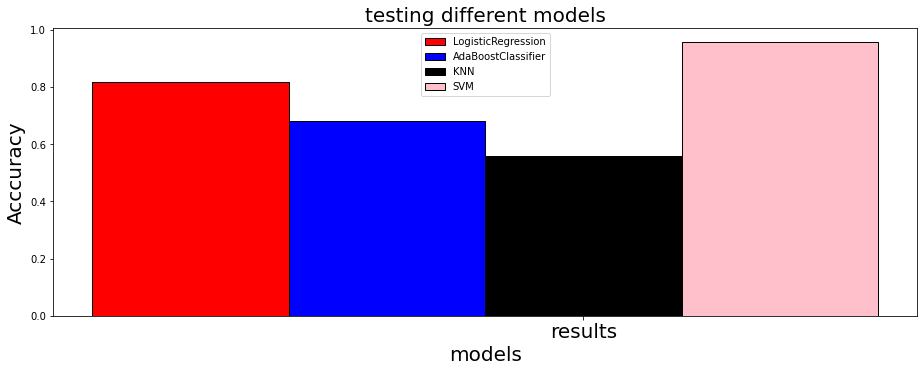

In [162]:
import matplotlib.pyplot as plt


def plot_dict(data, title, x_label):
    """
    creates bar plot for a given result dictionary
    """
    fig = plt.figure()
    ax = fig.add_axes([0,0,2,1])
    parameters = data.keys()
    tool_results = get_results(data)
    
    # plotting
    width = 0
    X = np.arange(len(data.keys()))
    colors = ['r', 'b', 'black', 'pink', 'yellow', 'orange']
    counter = 0
    width_increment = 1/(len(tool_results.keys())+2)
    for tool, results in tool_results.items():
        ax.bar(X + width, results, color = colors[counter], width = width_increment, label=tool, edgecolor='black')
        width += width_increment
        counter += 1
    plt.legend()
    plt.title(title, size=20)
    plt.ylabel("Acccuracy", size=20)
    plt.xlabel(x_label, size=20)
    ax.set_xticks(X+ (width_increment * 0.5 * len(tool_results.keys())))
    ax.set_xticklabels(parameters, size=20)

def get_results(data):
    """
    gets a tool specific results dictionary
    """
    tool_results = {}
    for result, result_dict in data.items():
        for tool, accuracy in result_dict.items():
            if tool == 'FFNN': accuracy = accuracy[1]
            accuracy = round(accuracy, 3)
            if tool in tool_results:
                tool_results[tool].append(accuracy)
            else:
                tool_results[tool] = [accuracy]
                
    return tool_results

"""
PLOTTING RESULTS
"""
results = test_models(X_test, Y_test, X_train, Y_train)
results = {'results' : results}
plot_dict(results, "testing different models", "models")

In [159]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, Sequential, models
from numpy import loadtxt

def test_models(test_x, test_y, train_x, train_y):
    score_dict = {'LogisticRegression': 0,
                  'AdaBoostClassifier' : 0,
                  'KNN' : 0,
                  'SVM' : 0,
                  #'FFNN' : 0
                 }
    
    # Logistic Regression
    print("logistic regression")
    LogisticRegression_i = LogisticRegression(random_state=0, max_iter=1000).fit(train_x, train_y)
    score_dict['LogisticRegression'] = LogisticRegression_i.score(test_x, test_y) 
    
    # Adaboost
    print("adaboost")
    AdaBoostClassifier_i = AdaBoostClassifier(n_estimators=100, random_state=0).fit(train_x, train_y)
    score_dict['AdaBoostClassifier'] = AdaBoostClassifier_i.score(test_x, test_y)
    
    # KNN
    print("KNN")
    KNN = KNeighborsClassifier(n_neighbors=2).fit(train_x, train_y)
    score_dict['KNN'] = KNN.score(test_x, test_y)  
    
    # SVM
    print("SVM")
    svc = svm.SVC().fit(train_x, train_y)
    score_dict['SVM'] = svc.score(train_x, train_y)    

    # FFNN
#     model = models.Sequential()
#     model.add(layers.Dense(len(train_x[0]), input_dim=len(train_x[0]), activation='relu'))
#     model.add(layers.Dense(500, activation='relu'))
#     model.add(layers.Dense(1, activation='sigmoid'))
#     batch_size = 1
#     epochs = 20
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     train_x = np.array(train_x)
#     train_y = np.array(train_y)
#     test_x, test_y = np.array(test_x), np.array(test_y)
#     model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, validation_data=(test_x, test_y))
#     score_dict['FFNN'] = model.evaluate(test_x, test_y)
    
    return score_dict

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

base_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', tol=1e-2, max_iter=500, random_state=123)

params = [{'C':[100, 10, 1.0, 0.1, 0.01]}]

gs_classifier = GridSearchCV(base_classifier, params, cv=10)
gs_classifier.fit(X_train, Y_train)

#print(gs_classifier.get_params())
print("Best parameter settings:", gs_classifier.best_params_)
print("Validation accuracy: %0.6f" % gs_classifier.best_score_)

KeyboardInterrupt: 

### 5.2 Model 2: SVM 

In [78]:
from sklearn.svm import SVC

base_classifier = SVC(random_state=123)

params = [{'kernel':['linear','rbf'], 'C': [100, 10, 1.0, 0.1, 0.01]}]

gs_classifier = GridSearchCV(base_classifier, params, cv=10)
gs_classifier.fit(X_train, Y_train)

print("Best parameter settings:", gs_classifier.best_params_)
print("Validation accuracy: %0.6f" % gs_classifier.best_score_)

Best parameter settings: {'C': 100, 'kernel': 'linear'}
Validation accuracy: 0.840033


### 5.3 Model 3: Random Forest

In [82]:
from sklearn.ensemble import RandomForestClassifier

base_classifier = RandomForestClassifier(random_state=123)

params = [{'n_estimators':[50, 100, 200, 300], 'min_samples_split': [2, 3, 6]}]

gs_classifier = GridSearchCV(base_classifier, params, cv=10)
gs_classifier.fit(X_train, Y_train)

print("Best parameter settings:", gs_classifier.best_params_)
print("Validation accuracy: %0.6f" % gs_classifier.best_score_)


Best parameter settings: {'min_samples_split': 2, 'n_estimators': 200}
Validation accuracy: 0.828907


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score

## 6. Evaluation